<a href="https://colab.research.google.com/github/cagBRT/Data/blob/main/5c_Outlier_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Do ML models make more mistakes with outliers?

Outliers are usually viewed with suspicion and are often removed. <br>

But Is this the best practice?


Sometimes, outliers are even more important than other observations. <br>

For example, the case of individuals that are outliers because they are very high-paying customers: you don’t want to discard them, if fact, you probably want to treat them with extra care.



In this notebook we try to answer the question: <br>

**Is an ML model more likely to make mistakes when making predictions on outliers?**

In [36]:
!pip install pycaret --quiet

In [26]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from scipy.stats import percentileofscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.ensemble import IsolationForest
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


In [27]:
DATASET_NAMES = [
  "bank",
  "blood",
  "cancer",
  "credit",
  "diabetes",
  "electrical_grid",
  "employee",
  "heart",
  "heart_disease",
  "hepatitis",
  "income",
  "juice",
  "nba",
  "wine",
  "telescope",
  "titanic",
  "us_presidential_election_results"]

**Define helper functions**

In [38]:
def get_dataset(dataset_name):
  """Get dataset."""
  target_name = datasets.loc[datasets["Dataset"]==dataset_name, "Target Variable 1"]
  df = get_data(dataset_name, verbose=False)
  X, y = df.drop(target_name, axis=1), df[target_name]
  y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])}).iloc[:,0]
  num_features = X.columns[X.apply(is_numeric)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  return X, y, num_features, cat_features

def is_numeric(x):
  """Check whether an object is numeric."""
  try:
    x+0
    return True
  except:
    return False

def individual_log_loss(y_true, y_pred, eps=1e-15):
  """Compute log-loss for each individual of the sample."""
  y_pred = np.clip(y_pred, eps, 1 - eps)
  return - y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred)


## Case 1

Let's look at a case where a model has been trained on the dataset shown below.

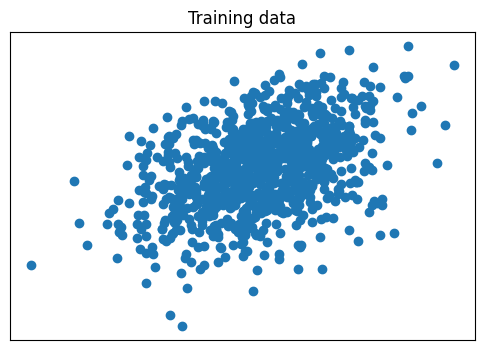

In [29]:
fig, ax = plt.subplots(figsize=(6,4))

x = np.random.multivariate_normal([0,0], [[1,.6],[.6,2]], size=1000)
ax.scatter(x[:,0], x[:,1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Training data")

fig.savefig(f"example_training.png", dpi=200, bbox_inches="tight")

**If new data is collected it can be**:
1. an outlier
2. falls within the standard range for data

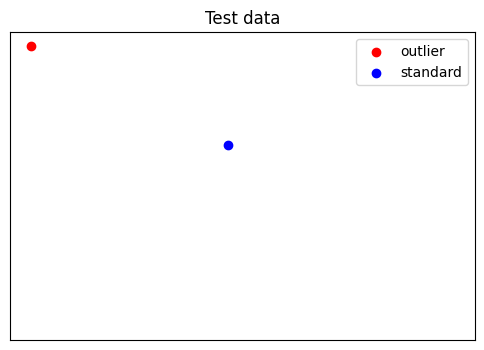

In [30]:
fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(x[:,0], x[:,1], color="white")
ax.scatter(np.min(x, axis=0)[0], np.max(x, axis=0)[1], color="red", label="outlier")
ax.scatter(np.quantile(x, q=.3, axis=0)[0], np.quantile(x, q=.7, axis=0)[1], color="blue", label="standard")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Test data")
ax.legend(loc="upper right")

fig.savefig(f"example_test.png", dpi=200, bbox_inches="tight")

**Question for discussion:** <br>
Is the outlier going to harder to predict than the standard data point?<br>



Three possible outcomes: <br>
1. outliers are harder to predict
2. outiers are easier to predict
3. outliers are neither harder or easier to predict

## Experiment 1

We use a bank customer datset. <br>

"bank": https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification

"telescope": https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope



**Get the bank dataset**<br>
The dataset contains:<br>

Personal information: <br>
- age, job, education level, and marital status<br>

account information: <br>
- balance, credit status,housing loan status, personal loan status<br>

marketing information: <br>
- contact method, day of week of last contact, month of last contact, length of last contact, number of contacts, number of contacts, outcome of last campaign<br>

Label: <br>
- the label will predict if the customer will purchase a bank term deposit (Yes=1, No=0)<br>

In [39]:
datasets = get_data(verbose=False)

In [40]:
dataset_name = "bank"
X, y, num_features, cat_features = get_dataset(dataset_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Training set:",X_train.shape, y_train.shape)
print("Test set:",X_test.shape, y_test.shape)

KeyError: "['deposit'] not found in axis"

**Split the dataset into training and test sets**

In [ ]:
X, y, num_features, cat_features = get_dataset(dataset_name)
X_train, X_test, y_train, y_test = train_test_split(X, y)

**All the inputs to the model**

In [ ]:
print("All features: ",X_train.columns)
print("Numerical features: ",num_features)

## Categorical Encoding with CatBoost Encoder<br>

We must convert the categorical data to numeric data. There are a number of categircial encoding methods we can use. <br>

In this case we care going to use Catboost. <br>

CatBooset encoding is used for categorical features.
There are various categorical encoding methods available. Catboost is one of them.<br>

Catboost is a target-based categorical encoder. It is a supervised encoder that encodes categorical columns according to the target value. It supports binomial and continuous targets.<br>
[Catboost is a target-based categorical encoder](https://www.geeksforgeeks.org/categorical-encoding-with-catboost-encoder/).  It encodes according to a target value and supports binomial and continuous targets. <br>

Target encoding replaces the categorical values with the average value for each column. This can introduce data leakage since the target is used to predict the target. <br>

Catboost solves the data leakage issue by using an ordering principle.





---



---



In [ ]:
# Make dataset
train = pd.DataFrame({
    'color': ["red", "blue", "blue", "green", "red",
              "red", "black", "black", "blue", "green"],

    'interests': ["sketching", "painting", "instruments",
                  "sketching", "painting", "video games",
                  "painting", "instruments", "sketching",
                  "sketching"],

    'height': [68, 64, 87, 45, 54, 64, 67, 98, 90, 87],

    'grade': [1, 2, 3, 2, 3, 1, 4, 4, 2, 3], })

# Define train and target
target = train[['grade']]
train = train.drop('grade', axis = 1)

# Define catboost encoder
cbe_encoder = CatBoostEncoder()

# Fit encoder and transform the features
cbe_encoder.fit(train, target)
train_cbe = cbe_encoder.transform(train)

# We can use fit_transform() instead of fit()
# and transform() separately as follows:
# train_cbe = cbe_encoder.fit_transform(train,target)
train_cbe



---

**End of CatBoostEncoder Example**

---



## Use CatBoostEncoder on our dataset

**The inputs for CatBoost**

In [ ]:
print("CatBoost features: ",cat_features)

**The data before CatBoost**

In [ ]:
X_train

In [ ]:
X_train.isna().sum()

In [ ]:
if len(cat_features) > 0:
  #fill empty values with NULL
    cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
  #transform the categorical data to numerical data
    X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
    X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
  #fill any missing data with the mean of the dataset
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_test.mean())

In [ ]:
X_train

In [ ]:
print("training dataset shape:",X_train.shape)
print("test dataset shape:",X_test.shape)

## Isolation Foreset

An Isolation Forest is an unsupervised model which can output a score of outlierness for each individual of your dataset.

It returns the anomaly score of each sample using the IsolationForest algorithm



**Identify outliers in the dataset**

In [ ]:
#The number of base estimators in the ensemble = 100
iforest = IsolationForest(n_estimators = 100).fit(X_train)
iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
print("Anomoly scores for the labels in the test set:\n",iforest_scores_test)

## LGB Classifier (Light Gradient Boosting Model)

LGB uses decision tree algorithms for ranking, classification, and other machine-learning tasks

In [ ]:
model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

## Log_loss

Log-loss is one of the major metrics to assess the performance of a classification problem.<br>

>"Log-loss is indicative of how close the prediction probability is to the corresponding actual/true value (0 or 1 in case of binary classification). The more the predicted probability diverges from the actual value, the higher is the log-loss value."



**What is log-loss?**<br>

A binary classification algorithm first predicts probability of a record to be classified under class 1 and then classifies the data point (record) under one of the two classes (1 or 0) based on whether the probability crossed a threshold value, which is usually set at 0.5 by default.<br>

![picture](https://github.com/cagBRT/Data/blob/main/images/logLoss.png?raw=1)<br>

Before predicting the class of the record, the model has to predict the probability of the record to be classified under class 1. Remember that it is this prediction probability of a data record that the log-loss value is dependent on.

In [ ]:
logloss_test = individual_log_loss(y_test, pred_test)
print(logloss_test)
#Each label with the probability of the record being classified as class 1

**Find the highest anomoly score**
1. Take the anomoly scores and sort them in asending order
2. id will equal the highest anomoly score

In [ ]:
id = iforest_scores_test.sort_values().tail(1).index[0]
id

In [ ]:
x = X_train.apply(lambda col: percentileofscore(col, X_test.loc[id, col.name])).sort_values(
    key=lambda x: np.abs(50-x), ascending=False).rename("quantile") / 100

print("Column name   score")
print(x)

In [ ]:
out = pd.concat([
    X.loc[id, x.index].rename("original data"),
    x
], axis=1).round(2)

out[(out["quantile"] > .95) | (out["quantile"] < .05)]
out

In [ ]:
#The max iforest_scores_test
print("this is the max outlierness scoure: ",iforest_scores_test.max())

In [ ]:
final=pd.concat([iforest_scores_test.rename("outlierness_test"),
           logloss_test.rename("logloss_test")], axis=1)
final

In [ ]:
#Get information about the customer with the highest outlierness
final.loc[out["outlierness_test"].idxmax()]

In [ ]:
print(X.loc[[43342]])

**Plot the outlierness for the data**

The higher the value, the more “extreme” the observation.

Deciding whether a specific individual is an outlier or not is an arbitrary choice.

Generally, we can say that the outliers lie on the right tail of this distribution.

In [ ]:
iforest_scores_test

## Bin the iforest_scores_test

**We are using the .hist() builtin function**<br>
This method uses numpy.histogram to bin the data in x and count the number of values in each bin, then draws the distribution either as a BarContainer or Polygon.

The bins, range, density, and weights parameters are forwarded to numpy.histogram.

In [ ]:
fig, ax1 = plt.subplots(figsize=(4,3))

ax1.hist(iforest_scores_test, color="darkblue")

ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")

fig.savefig(f"{dataset_name}_hist.png", dpi=200, bbox_inches="tight")

**At this point, we have two scores for each test observation**:<br>

1. score of outlierness (from Isolation Forest);
2. score of wrongness (log-loss).<br>

Our initial hypothesis is that they are positively correlated:
>the more weird a new observation, the more wrong its prediction.

To assess if this is true, we can plot the same histogram we have already seen, but this time we will also visualize the average log-loss of each bin.



In [ ]:
cut=pd.cut(iforest_scores_test, bins=10)
logloss = logloss_test.groupby(cut).mean()

fig, ax1 = plt.subplots(figsize=(4,3))

ax2 = ax1.twinx()
ax1.hist(iforest_scores_test, color="darkblue")
ax2.plot([i.mid for i in logloss.index], logloss, color="red")

ax1.set_title(dataset_name)
ax1.set_xlabel("outlierness")
ax1.set_ylabel("n obs", color="darkblue")
ax2.set_ylabel("log loss", color="red")

fig.savefig(f"{dataset_name}_hist_logloss.png", dpi=200, bbox_inches="tight")

The correlation between outlierness and log-loss is clearly positive. <br>

This means that, in this dataset, outliers are actually harder to predict (i.e. they tend to have a higher log-loss).

## Repeat for the other datasets

In [ ]:
dataset_names = []

for dataset_name in DATASET_NAMES:
    X, y, num_features, cat_features = get_dataset(dataset_name)

    if len(X) > 5000:
        dataset_names.append(dataset_name)

In [ ]:

results = []

for dataset_name in tqdm(dataset_names):
    X, y, num_features, cat_features = get_dataset(dataset_name)

    for iteration in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        if len(cat_features) > 0:
            cat_encoder = CatBoostEncoder().fit(X_train[cat_features].fillna("NULL"), y_train)
            X_train[cat_features] = cat_encoder.transform(X_train[cat_features])
            X_test[cat_features] = cat_encoder.transform(X_test[cat_features])
            X_train = X_train.fillna(X_train.mean())
            X_test = X_test.fillna(X_train.mean())
        iforest = IsolationForest(n_estimators = 100).fit(X_train)
        iforest_scores_test = pd.Series(-iforest.score_samples(X_test), index=X_test.index)
        model = LGBMClassifier(verbose=-1).fit(X_train, y_train)
        pred_test = pd.Series(model.predict_proba(X_test)[:,1], index=X_test.index)
        logloss_test = individual_log_loss(y_test, pred_test)

        iforest_q95 = iforest_scores_test.quantile(.95)
        outliers_vs_rest = (iforest_scores_test > iforest_q95).replace({True: "outliers", False: "rest"})
        logloss = logloss_test.groupby(outliers_vs_rest).mean()

        results.append({
            "dataset name": dataset_name,
            "iteration": iteration,
            "n outliers": (iforest_scores_test > iforest_q95).sum(),
            "log-loss": logloss.mean(),
            "log-loss (outliers)": logloss["outliers"],
            "log-loss (rest)": logloss["rest"]
        })

In [ ]:
results_agg = pd.DataFrame(results).groupby("dataset name").agg({
    "dataset name": lambda x: x.values[0],
    "iteration": lambda x: len(x),
    "n outliers": np.min,
    "log-loss": np.mean,
    "log-loss (outliers)": np.mean,
    "log-loss (rest)": np.mean,
})

results_agg["ratio"] = np.maximum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"]) / np.minimum(results_agg["log-loss (outliers)"], results_agg["log-loss (rest)"])
results_agg = results_agg.sort_values("ratio", ascending=False)

For the sake of simplicity, consider all observations above the 95th percentile of outlierness as outliers.

In [ ]:
results_agg.loc[:,["log-loss","log-loss (outliers)","log-loss (rest)"]].round(3) \
    .style.apply(lambda x: ["background: red" if (v > results_agg["log-loss"].iloc[e] and x.name =="log-loss (outliers)") else ("background: lightgreen" if x.name=="log-loss (outliers)" else "") for e, v in enumerate(x)])


## For this experiment:<br>

1. For some datasets outliers are hard to predict
>bank dataset (outliers have higher logloss than rest of dataset)
2. For some datasets outliers are easier to predict
>telescope (outliers have lower logloss)
3. For some datasets there is not a lot difference
>wine, income, electrical_grid, credit, employee



## Conclusion:<br>

**The question:** Do ML models make more mistakes with outliers?

**The answer:** it depends



---



---



**Answers to the question for discussion:**<br>
Since the outlier is in a very “sparse” area, it could be harder to predict because the model has few training cases in this area. <br>

Yet, the opposite case is also possible: <br>
>If the decision threshold is done in such a way that the observations that are near the center of the distribution are associated with more uncertainty (i.e. true probability close to 50%) <br>

>This would lead to decisions at the periphery of the distribution have a very high expected probability of being positive (i.e. true probability equal to 90%). In this case, even if there are fewer cases to learn from, the model may be more correct.

Or, there is a middle opinion: <br>
outliers are neither harder nor easier to predict than standard observations.